In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid", context='talk', palette='Greys')
%load_ext rpy2.ipython

## Distribution of the data

In [2]:
data = pd.read_csv("../data/bias_symptoms_rf.csv", index_col=[0, 1])

In [3]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    g.set_axis_labels("", symp_name)
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=13.031021669308084, pvalue=4.919598042071244e-38)
Ttest_indResult(statistic=6.32710877677299, pvalue=2.698106194973017e-10)
Ttest_indResult(statistic=10.59290129293871, pvalue=6.46893564801603e-26)
(0.18086859662751908, 'small')
(0.16370106599147521, 'small')
(0.17479160729552579, 'small')


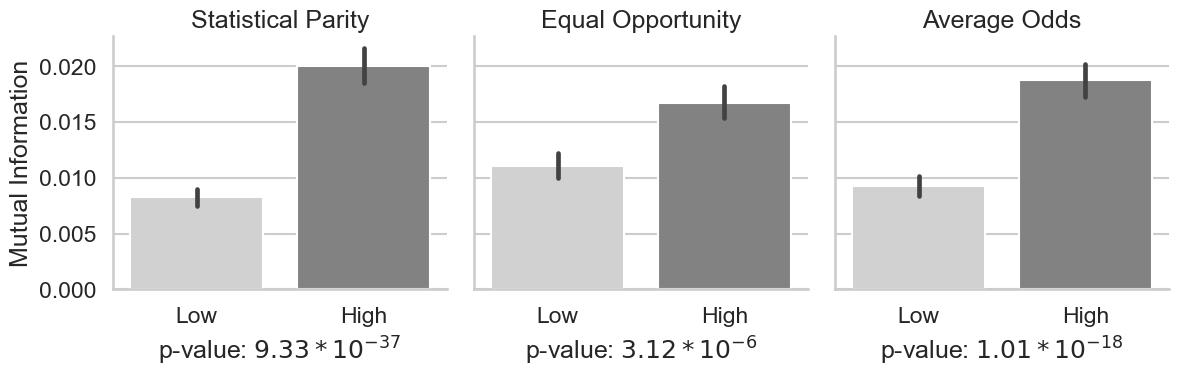

In [4]:
g = plot_differences(data, "mutual_info", "Mutual Information")
g.facet_axis(0, 0).set_xlabel(
    "p-value: $9.33*10^{-37}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 1).set_xlabel(
    "p-value: $3.12*10^{-6}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: $1.01*10^{-18}$", labelpad=5, fontdict={"fontsize": 18}
)
plt.savefig("figs/Mutual Information.pdf", bbox_inches="tight")
plt.show()

## Kendall's Tau

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=4.289320975345808, pvalue=1.8264908473410818e-05)
Ttest_indResult(statistic=1.3526368943310916, pvalue=0.17622608545989327)
Ttest_indResult(statistic=4.049807076249995, pvalue=5.20327552298651e-05)
(0.061772380386601475, 'negligible')
(-0.015335229884683698, 'negligible')
(0.05513843523247912, 'negligible')


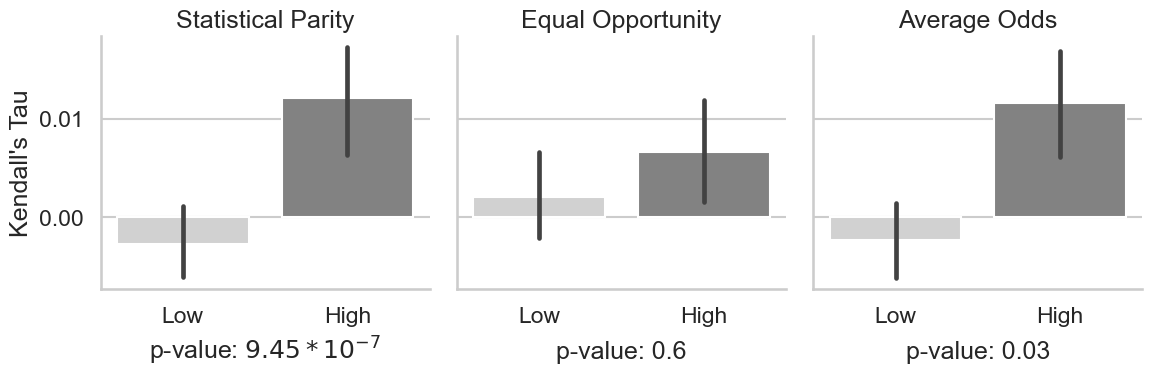

In [5]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")

g.facet_axis(0,0).set_xlabel("p-value: $9.45*10^{-7}$", labelpad=5, fontdict={'fontsize': 18})
g.facet_axis(0, 1).set_xlabel(
    "p-value: 0.6", labelpad=10, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: 0.03", labelpad=10, fontdict={"fontsize": 18}
)
plt.savefig("figs/Kendall's Tau.pdf", bbox_inches="tight")
plt.show()

## Metrics Distribution

In [6]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [7]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Percentage')

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_74378/2928899263.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


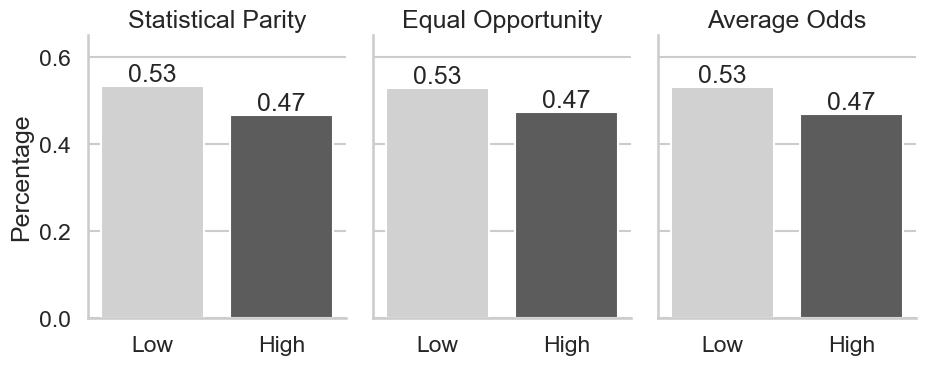

In [8]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Percentage",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[1:5:3],
    height=4,
    aspect=0.8,
)


for i in range(3):
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[0], fmt="%.2f")
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[1], fmt="%.2f")

g.set_titles("{col_name}")
# plt.subplots_adjust(top=1.3)
g.set_axis_labels("")
plt.ylim(0,0.65)
plt.tight_layout()
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()

## Distribution of SP, EO and AO

In [9]:
raw = pd.read_csv("../data/bias_symptoms_raw_rf.csv", index_col=[0, 1])
metrics = raw[['statistical_parity', 'equal_opportunity', 'average_odds']]
metrics = pd.melt(metrics, var_name='Metric', value_name='Value')
metrics['Metric'] = metrics['Metric'].map({'statistical_parity': 'Statistical Parity', 'equal_opportunity': 'Equal Opportunity', 'average_odds': 'Average Odds'})
metrics['Value'] = metrics['Value'].abs()

In [10]:
raw[['statistical_parity', 'equal_opportunity', 'average_odds']].abs().describe()

,statistical_parity,equal_opportunity,average_odds
count,5930.000000,5893.000000,5930.000000
mean,0.215282,0.156795,0.204259
std,0.197168,0.188213,0.208482
min,0.000000,0.000000,0.000000
25%,0.043974,0.012281,0.025523
50%,0.181974,0.088699,0.125000
75%,0.312712,0.230769,0.334827
max,1.000000,1.000000,1.000000


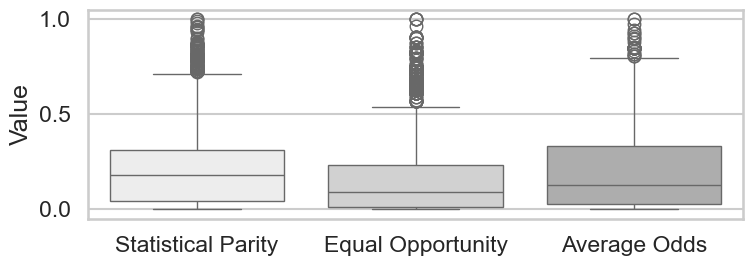

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=metrics, x='Metric', y='Value', hue='Metric')
plt.xlabel('')
plt.tight_layout()
plt.savefig('figs/metrics_boxplot.pdf', bbox_inches='tight')
plt.show()

## Distribution of unbalance between items with high SP and low SP

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


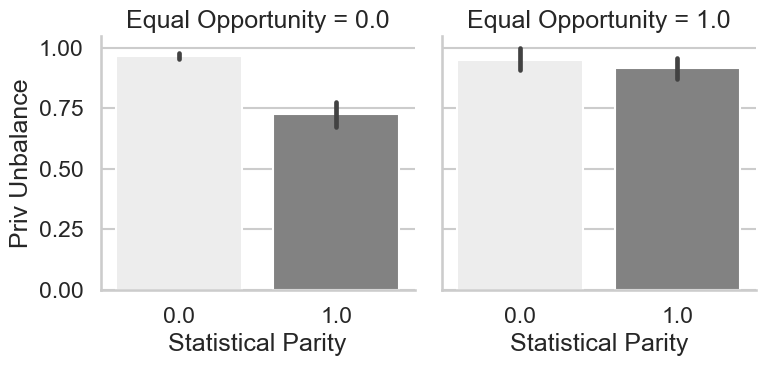

In [12]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# sns.barplot(data=high_prec[high_prec['equal_opportunity'] == 0], y="priv_unbalance", hue="statistical_parity", ax=ax[0])
# sns.barplot(
#     data=low_prec[low_prec["equal_opportunity"] == 0],
#     y="priv_unbalance",
#     hue="statistical_parity",
#     ax=ax[1],
# )

fig = sns.FacetGrid(data, col="equal_opportunity", height=4, aspect=1)
fig.map(
    sns.barplot,
    "statistical_parity",
    "priv_unbalance",
    "statistical_parity",
    hue_order=[0, 1],
    palette=sns.color_palette()[0:4:3],
)
fig.set_titles("Equal Opportunity = {col_name}")
fig.figure.axes[0].set_xlabel("Statistical Parity")
fig.figure.axes[1].set_xlabel("Statistical Parity")
fig.set_ylabels("Priv Unbalance")
fig.tight_layout()
plt.savefig("figs/priv_unbalance.pdf", bbox_inches="tight")
# sns.barplot(
#     data=data[data["equal_opportunity"] == 0],
#     y="priv_unbalance",
#     hue="statistical_parity"
# )

## REDUN Algorithm

In [13]:
data.reset_index(inplace=True)

In [14]:
%%R -i data
library(tidyverse)
library(Hmisc)


data <- data %>% select(-data, -variable)
m <- redun(as.matrix(data, r2 = 0.8, nk = 0))
reducedData <- m$In
data <- data[, reducedData]
data %>% colnames()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
 [1] "correlation_true"   "mutual_info"        "unpriv_prob_pos"   
 [4] "unpriv_unbalance"   "priv_unbalance"     "statistical_parity"
 [7] "equal_opportunity"  "average_odds"       "skew_var"          
[10] "gini"               "simpson"            "shannon"           
[13] "ir"                 "pos_prob"          



Caricamento pacchetto: ‘Hmisc’

I seguenti oggetti sono mascherati da ‘package:dplyr’:

    src, summarize

I seguenti oggetti sono mascherati da ‘package:base’:

    format.pval, units



In [15]:
data_new = data[
    [
      "data", "variable",
        "correlation_true",
        "mutual_info",
        "unpriv_prob_pos",
        "unpriv_unbalance",
        "priv_unbalance",
        "statistical_parity",
        "equal_opportunity",
        "average_odds",
        "skew_var",
        "gini",
        "simpson",
        "shannon",
        "ir",
        "pos_prob"
    ]
]

In [16]:
data_new.columns

Index(['data', 'variable', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'unpriv_unbalance', 'priv_unbalance',
       'statistical_parity', 'equal_opportunity', 'average_odds', 'skew_var',
       'gini', 'simpson', 'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [17]:
data.columns

Index(['variable', 'data', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'priv_prob_pos', 'unpriv_unbalance',
       'priv_unbalance', 'statistical_parity', 'equal_opportunity',
       'average_odds', 'kurtosis_var', 'skew_var', 'gini', 'simpson',
       'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [18]:
data_new.to_csv("../data/bias_symptoms_rf_reduced.csv", index=False)

## Correlation analysis

In [19]:
raw = raw.reset_index()

In [20]:
raw_new = raw[
    [
        "data",
        "variable",
        "correlation_true",
        "mutual_info",
        "unpriv_prob_pos",
        "unpriv_unbalance",
        "priv_unbalance",
        "statistical_parity",
        "equal_opportunity",
        "average_odds",
        "skew_var",
        "gini",
        "simpson",
        "shannon",
        "ir",
        "pos_prob",
    ]
]

In [21]:
raw_new

,data,variable,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,skew_var,gini,simpson,shannon,ir,pos_prob
0,arrhythmia,1,-0.329830,0.263048,0.250000,0.575000,1.326923,-0.257692,0.130769,-0.072727,-0.272071,0.080404,0.029740,0.999956,0.769208,0.326923
1,arrhythmia,23,0.071520,0.075555,0.454545,1.045455,0.000000,0.727273,0.340909,0.750000,4.629568,0.110091,0.016495,0.999949,0.045361,0.454545
2,arrhythmia,24,0.152653,0.042323,0.444444,1.022222,0.000000,-0.311111,-0.688889,0.220000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
3,arrhythmia,26,0.021056,0.055834,0.444444,1.022222,0.000000,0.711111,0.333333,0.740000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
4,arrhythmia,38,0.110542,0.104732,0.444444,1.022222,0.000000,0.711111,0.333333,0.740000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,ibm,MaritalStatus_Divorced,-0.095871,0.005095,0.798319,0.977941,1.093750,-0.067227,0.077731,-0.119956,1.592781,0.101727,0.002141,0.999786,0.235219,0.094538
5926,ibm,MaritalStatus_Married,-0.058910,0.001746,0.794872,0.973718,1.029710,-0.020624,-0.007246,-0.070369,0.123947,0.085857,0.002951,0.999796,0.884604,0.045708
5927,ibm,MaritalStatus_Single,0.141521,0.009645,0.855670,1.048196,0.906500,0.069072,-0.045361,0.119597,0.681858,0.093211,0.002687,0.999794,0.515416,0.115670
5928,ibm,OverTime_No,-0.306588,0.044253,0.645833,0.791146,1.101263,-0.166667,0.211490,-0.195446,-0.747479,0.074244,0.002644,0.999793,0.484798,0.253157


In [22]:
sp = raw_new.pop('statistical_parity').abs()
eo = raw_new.pop("equal_opportunity").abs()
ao = raw_new.pop("average_odds").abs()

raw_new.insert(len(raw_new.columns), "statistical_parity", sp)
raw_new.insert(len(raw_new.columns), "equal_opportunity", eo)
raw_new.insert(len(raw_new.columns), "average_odds", ao)

In [23]:
kendall = raw_new.drop(columns=['variable', 'data']).corr("spearman").round(3)
for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if np.abs(kendall.loc[col, col2]) > 0.95:
            kendall.loc[col, col2] = r"\cellcolor{black!25}\textbf{" + str(kendall.loc[col, col2]) + "}"
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

In [24]:
upper = kendall.where(np.triu(np.ones(kendall.shape), k=1).astype(bool))

In [25]:
upper

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
correlation_true,NaN,0.047*,0.021,-0.077,-0.104,0.027*,0.029*,0.041,0.04,0.002*,0.07,0.066,-0.006*,0.061
mutual_info,NaN,NaN,0.207,0.123,-0.021*,-0.391,-0.391,0.38,0.375,0.414,0.46,0.261,0.137,0.175
unpriv_prob_pos,NaN,NaN,NaN,0.184,0.02*,-0.081,-0.073,0.783,0.782,0.181,0.141,0.08,0.285,-0.004
unpriv_unbalance,NaN,NaN,NaN,NaN,-0.687,0.035*,0.046*,0.041,0.041,0.068,0.0*,-0.004*,0.012*,0.05
priv_unbalance,NaN,NaN,NaN,NaN,NaN,-0.162,-0.163,0.141,0.141,0.149,-0.106,-0.091,0.054*,-0.286
skew_var,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.994},-0.333,-0.327,-0.877,0.4,0.4,0.416,0.271
gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.337,-0.331,-0.872,0.385,0.386,0.413,0.26
simpson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.999},0.412,0.1,0.056,0.294,-0.05
shannon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405,0.102,0.059,0.295,-0.047
ir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.458,-0.462,-0.377,-0.374


In [26]:
upper.to_latex('full_corr.tex', float_format="%.3f", escape=False, na_rep="-")

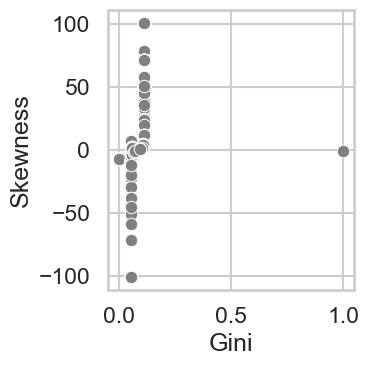

In [30]:
# fig, ax = plt.subplots(1,3,figsize=(12, 4))
fig, ax = plt.subplots(figsize=(4, 4))
fig = sns.scatterplot(data=raw_new, x="gini", y="skew_var", color='grey', ax=ax)
fig.axes.set_xlabel("Gini")
fig.axes.set_ylabel("Skewness")
# fig.set_title("Gini and Skewness Relationship")
fig.figure.tight_layout()
fig.figure.savefig("figs/gini_skew.pdf", bbox_inches="tight")
plt.show()

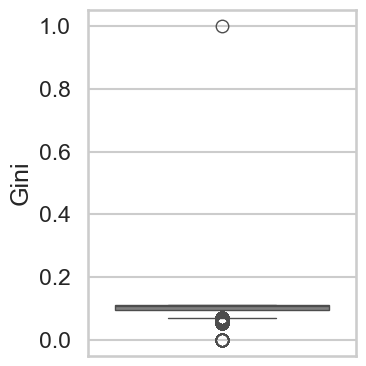

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(data=raw_new, y="gini", color='grey', ax=ax)
fig.axes.set_ylabel("Gini")
# fig.axes.set_title("Gini Distribution")
fig.figure.tight_layout()
fig.figure.savefig("figs/gini_distr.pdf", bbox_inches="tight")
plt.show()

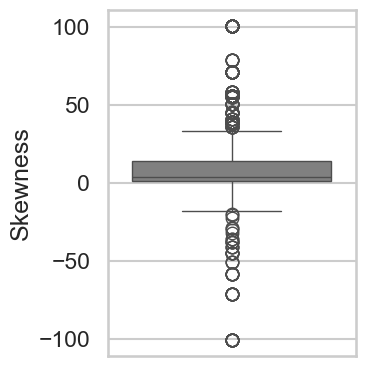

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(data=raw_new, y="skew_var", color='grey', ax=ax)
fig.axes.set_ylabel("Skewness")
# fig.axes.set_title("Skewness Distribution")
fig.figure.tight_layout()
fig.figure.savefig("figs/skew_distr.pdf", bbox_inches="tight")
plt.show()

In [33]:
raw_new[raw_new['gini'] == 1]

,data,variable,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
5633,crime,MedNumBR,-0.380867,0.105544,0.0,0.0,1.0,-0.602467,1.0,0.001494,0.999701,0.554644,0.271357,0.281407,NaN,0.396488


<Axes: xlabel='statistical_parity', ylabel='average_odds'>

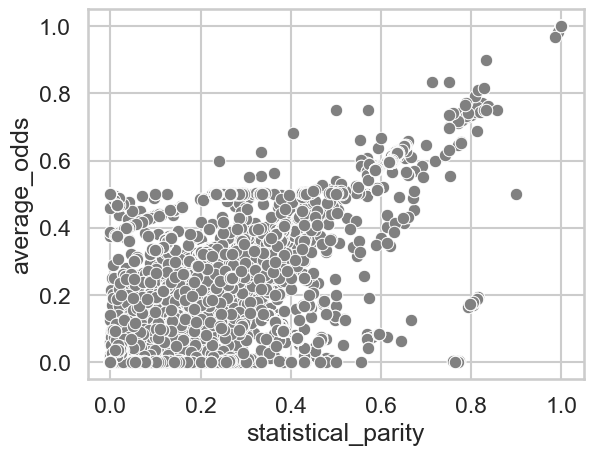

In [38]:
sns.scatterplot(data=raw_new, x="statistical_parity", y="average_odds", color='grey')